# Convolutional Neural Network Using Keras
In this notebook, I create a convolutional neural network(CNN) using keras to classify knee images that are stored in my local computer. The goal is to predict whether an image shows an injured knee or not.

In [1]:
### importing required libraries
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D, BatchNormalization,LeakyReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import adam
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from numpy import *
import tensorflow

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
%matplotlib inline

C:\Users\tnguy\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\tnguy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Getting directories in which the images are stored
"""directories for uncropped images"""

path1 = r'C:\Users\tnguy\Downloads\TE_image_case'
path2 = r'C:\Users\tnguy\Downloads\TE_images_resized'

### Create a function that copy images from the given path to another path
def copy_images(path1, path2):
    listing = os.listdir(path1)   ### get a list of images from the given path1
    num_samples = size(listing)
    print(num_samples)
    img_rows, img_cols = 224, 224
    for file in listing:          ### convert the images in to gray scale then save them into path2
        im = Image.open(path1+'\\'+file)
        img = im.resize((img_rows, img_cols))
        gray = img.convert('L')
        gray.save(path2 +'\\' + file, 'JPEG')
###         
def get_images(path2):
    imlist = os.listdir(path2)
    ### get the shape of an image as well as the number of images in the given path
    im1 = array(Image.open(path2 + '\\' + imlist[0]))
    m,n = im1.shape[0:2]
    imnbr = len(imlist)
    ### Flatten and transform the images into a numpy array for manipulation
    immatrix = array([array(Image.open(path2 + '\\' + im2)).flatten() for im2 in imlist], 'f')
    return immatrix

### Create a function that would take an array as an argument, append that array into a list then return that list
lists = []
def transform_array(array, lists):
    for i in range(len(array)):
        lists.append(array[i])
    return lists

### Execute the functions created
copy_images(path1,path2)
immatrix = get_images(path2)
lists = np.array(transform_array(immatrix, lists))

### this is the nummber of images
num_samples = len(lists)

171


In [3]:
img_rows, img_cols = 224, 224
img_channels = 1
nb_classes = 2

### Original Image

(171, 50176)
(171,)


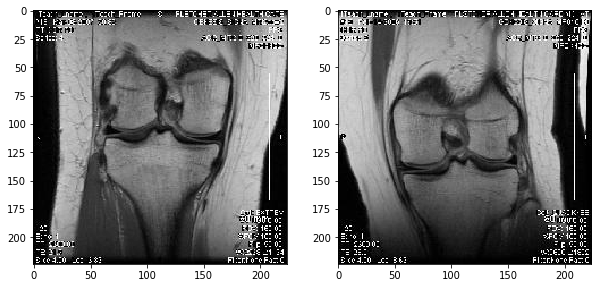

In [4]:

label = np.ones((num_samples,) ,dtype = int)
"""the set of 171 images has 68 control cases"""
label[0:69] = 0
label[69:171] = 1

""" shuffle trainning data then put it in a train_data list"""
data, label = shuffle(lists, label, random_state=4)
train_data = [data,label]
""" This function shows two images x,y in gray scale from the pool of images"""
def show_im(x,y, lists):
    img=lists[x].reshape(img_rows,img_cols)
    img1=lists[y].reshape(img_rows,img_cols)
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[1].imshow(img, cmap='gray')
    ax[0].imshow(img1, cmap='gray')
    
### Execute the function
show_im(39,80, lists)


### print out the shape of the images: there are 171 images and the second dimension is the product of 224*224
print(train_data[0].shape)
print(train_data[1].shape)

### Splitting trainning, test and validation sets

In [5]:
""" Split training data into training, validation and test sets"""
(X,y) = (train_data[0], train_data[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=4)

### Reshaping and Standardization
The images' dimensions need to be standardized for the CNN to run smoothly

In [6]:

""" reshape the data to put in the CNN"""
X_train = X_train.reshape(X_train.shape[0],img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

### Normalize the pixel by dividing them by 225
X_train /= 225
X_test /= 225
X_val /= 225

X = X.reshape(X.shape[0],img_rows, img_cols,1)
X /= 225

### print out the shape of X_train and the samples of the train and test sets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train_samples')
print(X_test.shape[0], 'test_samples')
print(X_val.shape[0], 'val_samples')

X_train shape: (108, 224, 224, 1)
108 train_samples
35 test_samples
28 val_samples


### One Hot encode the labels for the CNN to work

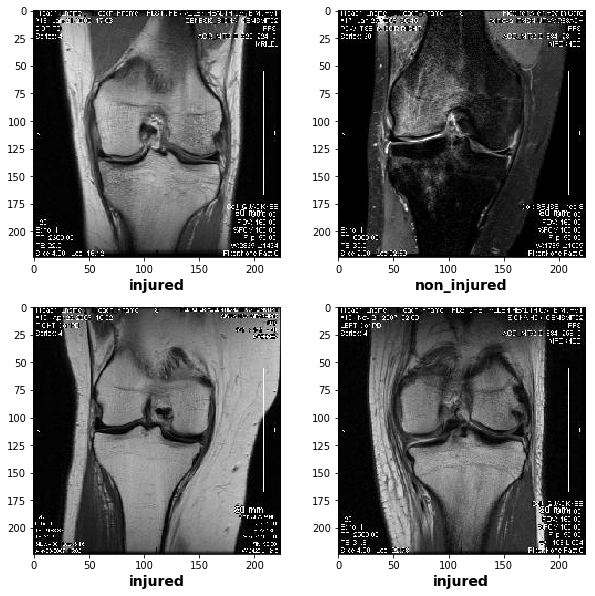

In [7]:
### hot code the labels for categorization purpose
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
y = np_utils.to_categorical(y, nb_classes)
plt.figure(figsize=(10,10))
class_names = ['non_injured', 'injured']

### print out the first five images 
for i in range(5):
    if i == 0:
        pass
    else:
        plt.subplot(2,2,i)
        plt.imshow(X_train.reshape(X_train.shape[0],1, img_rows, img_cols)[i,0], interpolation = 'nearest', cmap='gray')
        plt.xlabel(class_names[y_train[i]],fontsize = 14, fontweight='bold')

plt.savefig('knees_image.png')

In [8]:
batch_size = 32
np_epoch = 2
nb_pool = 2
nb_conv = 3
nb_filters1 = 32
nb_filters2 = 64

### A simple CNN with two convolutional layers

In [9]:
model1=Sequential()
model1.add(Conv2D(16, kernel_size=3, input_shape=(img_rows, img_cols,1), 
                  activation='relu', padding='same'))
model1.add(MaxPool2D(2))
model1.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
#model1.add(Dropout(0.5))
model1.add(MaxPool2D(2))

model1.add(Flatten())
model1.add(Dense(2, activation='sigmoid'))
#model1.add(Dropout(0.25))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

training1 = model1.fit(X_train,Y_train
                       ,batch_size=batch_size
                       ,validation_data = [X_val, Y_val]
                        ,epochs=30)
test_loss, test_acc = model1.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)


Train on 108 samples, validate on 28 samples
Epoch 1/30
108/108 [==============================] - 3s 29ms/step - loss: 0.8011 - acc: 0.6343 - val_loss: 0.8153 - val_acc: 0.3393
Epoch 2/30
108/108 [==============================] - 3s 25ms/step - loss: 0.5833 - acc: 0.7130 - val_loss: 0.5947 - val_acc: 0.6786
Epoch 3/30
108/108 [==============================] - 3s 23ms/step - loss: 0.4950 - acc: 0.7130 - val_loss: 0.6081 - val_acc: 0.7143
Epoch 4/30
108/108 [==============================] - 2s 22ms/step - loss: 0.4209 - acc: 0.8657 - val_loss: 0.6871 - val_acc: 0.6429
Epoch 5/30
108/108 [==============================] - 3s 25ms/step - loss: 0.3959 - acc: 0.8241 - val_loss: 0.7242 - val_acc: 0.6964
Epoch 6/30
108/108 [==============================] - 3s 24ms/step - loss: 0.3335 - acc: 0.8519 - val_loss: 0.7562 - val_acc: 0.7321
Epoch 7/30
108/108 [==============================] - 2s 20ms/step - loss: 0.2935 - acc: 0.8889 - val_loss: 0.8213 - val_acc: 0.7500
Epoch 8/30
108/108 [====

According to the results, the model is suffering from overfitting. Because the trainning accuracy is almost 100% but the validation accuracy is only 79%. One method to alleviate overfitting is regularization through dropout. Dropout will shut down cartain neurons in a layer if such neuron does not exceed a given threshold. 


### CNN with Dropout

In [17]:
### Adding a dropout layer with a threshold of 0.5
model3=Sequential()
model3.add(Conv2D(8, kernel_size=3, input_shape=(img_rows, img_cols,1), 
                  activation='relu', padding='same'))
model3.add(MaxPool2D(2))
model3.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
model3.add(Dropout(0.5))
model3.add(MaxPool2D(2))

model3.add(Flatten())
model3.add(Dense(2, activation='sigmoid'))
#model3.add(Dropout(0.25))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

training3 = model3.fit(X_train,Y_train
                       ,batch_size=batch_size
                       ,validation_data = [X_val, Y_val]
                        ,epochs=30)

Train on 108 samples, validate on 28 samples
Epoch 1/30
108/108 [==============================] - 2s 18ms/step - loss: 0.8949 - acc: 0.5833 - val_loss: 0.8450 - val_acc: 0.3571
Epoch 2/30
108/108 [==============================] - 2s 14ms/step - loss: 0.7481 - acc: 0.6019 - val_loss: 0.6004 - val_acc: 0.7143
Epoch 3/30
108/108 [==============================] - 2s 16ms/step - loss: 0.5824 - acc: 0.6528 - val_loss: 0.6150 - val_acc: 0.7143
Epoch 4/30
108/108 [==============================] - 1s 13ms/step - loss: 0.5559 - acc: 0.7315 - val_loss: 0.6152 - val_acc: 0.6071
Epoch 5/30
108/108 [==============================] - 1s 13ms/step - loss: 0.4755 - acc: 0.8056 - val_loss: 0.6319 - val_acc: 0.6964
Epoch 6/30
108/108 [==============================] - 1s 14ms/step - loss: 0.4698 - acc: 0.7824 - val_loss: 0.6412 - val_acc: 0.6786
Epoch 7/30
108/108 [==============================] - 1s 14ms/step - loss: 0.4219 - acc: 0.8194 - val_loss: 0.6167 - val_acc: 0.7679
Epoch 8/30
108/108 [====

In [11]:
test_loss, test_acc = model3.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

35/35 [==============================] - 0s 5ms/step
Test accuracy: 0.657142857994352


### CNN with data augmentation and early stopping
One method to increase the trainning data is using data augmentation. For example, cropping is a data augmentation technique. Early stopping will save the best model and stop the trainning process if it finds that the trainning does not improve after a given number of epochs. Early stopping serves as a regularization method, thereby eliminating the need to use dropout. 

In [12]:
### Data Agumentation: zoom in, flip horizontally and vertically
generator = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
#            rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
#            width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
#            height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)
### We'll stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('best_model1.h5'
                                ,monitor='val_acc'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)
generator.fit(X_train)
model2=Sequential()
model2.add(Conv2D(16, kernel_size=3, input_shape=(img_rows, img_cols,1), 
                  activation='relu', padding='same'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model2.add(Dropout(0.5))
model2.add(MaxPool2D(2))

model2.add(Flatten())
model2.add(Dense(34, activation = 'relu'))
model2.add(Dense(2, activation='sigmoid'))
#model2.add(Dropout(0.25))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

training2 = model2.fit_generator(generator.flow(X_train,Y_train
                        ,batch_size=batch_size)
                        ,epochs=20
                        ,validation_data=[X_val, Y_val]
                        ,steps_per_epoch=16
                        ,callbacks=[earlystopper1, checkpointer1])

test_loss, test_acc = model2.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

Epoch 1/20
16/16 [==============================] - 11s 662ms/step - loss: 0.7502 - acc: 0.5033 - val_loss: 0.6603 - val_acc: 0.7143

Epoch 00001: val_acc improved from -inf to 0.71429, saving model to best_model1.h5
Epoch 2/20
16/16 [==============================] - 10s 611ms/step - loss: 0.6556 - acc: 0.6486 - val_loss: 0.6339 - val_acc: 0.7143

Epoch 00002: val_acc did not improve from 0.71429
Epoch 3/20
16/16 [==============================] - 10s 606ms/step - loss: 0.6301 - acc: 0.6543 - val_loss: 0.6248 - val_acc: 0.7321

Epoch 00003: val_acc improved from 0.71429 to 0.73214, saving model to best_model1.h5
Epoch 4/20
16/16 [==============================] - 10s 610ms/step - loss: 0.6222 - acc: 0.6587 - val_loss: 0.6133 - val_acc: 0.7321

Epoch 00004: val_acc did not improve from 0.73214
Epoch 5/20
16/16 [==============================] - 10s 617ms/step - loss: 0.5944 - acc: 0.6721 - val_loss: 0.6768 - val_acc: 0.6429

Epoch 00005: val_acc did not improve from 0.73214
Epoch 6/20


Out of the three models, the first model shows the best results. Let's look at the overall performance.


### Overall performance

In [13]:
from sklearn import metrics
def eval_test_set(model, X_test, Y_test):
    model.load_weights('best_model1.h5')
    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(Y_test, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=('non-injured', 'injured')))
    test_res = model.evaluate(X_test, Y_test, verbose = 0)
    print(model.predict_classes(X_test[1:5]))
    print(Y_test[1:5])
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
    
eval_test_set(model2, X_test, Y_test)

             precision    recall  f1-score   support

non-injured       1.00      0.20      0.33        20
    injured       0.48      1.00      0.65        15

avg / total       0.78      0.54      0.47        35

[0 1 1 1]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Loss function: 0.7913156134741647, accuracy: 0.5571428571428572


In [14]:
def eval_test_set1(model, X_test, Y_test):
    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(Y_test, axis=1)
    print(metrics.classification_report(test_truth, test_pred, target_names=('non-injured', 'injured')))
    test_res = model.evaluate(X_test, Y_test, verbose = 0)
    print(model.predict_classes(X_test[1:5]))
    print(Y_test[1:5])
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
eval_test_set1(model1, X_test, Y_test)
eval_test_set1(model3, X_test, Y_test)

             precision    recall  f1-score   support

non-injured       1.00      0.45      0.62        20
    injured       0.58      1.00      0.73        15

avg / total       0.82      0.69      0.67        35

[0 1 1 1]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Loss function: 1.068110486439296, accuracy: 0.6714285722800664
             precision    recall  f1-score   support

non-injured       1.00      0.40      0.57        20
    injured       0.56      1.00      0.71        15

avg / total       0.81      0.66      0.63        35

[0 1 1 1]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Loss function: 0.6218625238963535, accuracy: 0.657142857994352


The overall performance score shows that the simple CNN model performs better than the rest. 

### Plotting the results

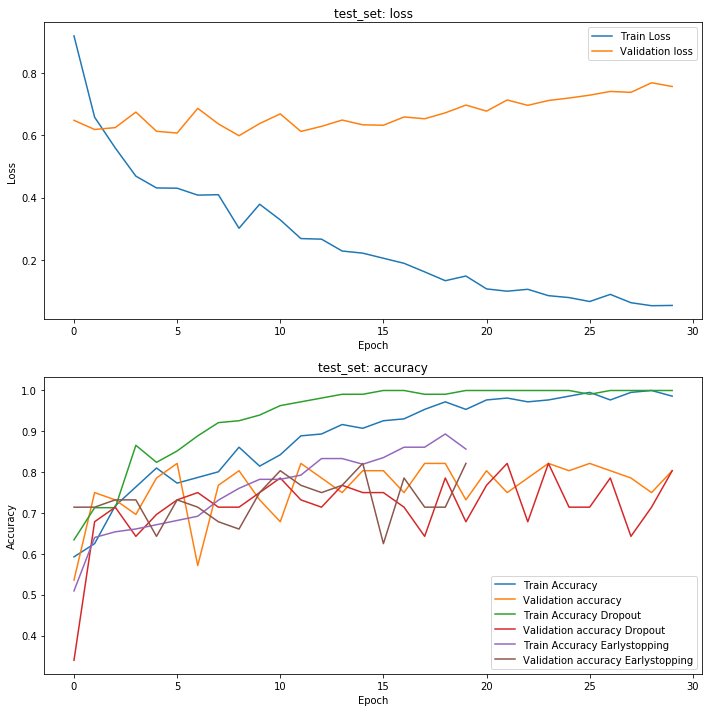

In [15]:
def eval_model1(training, training_more, training_mores, model, test_X, test_y, field_name, image_name, model_name1, model_name2):
    f, ax = plt.subplots(2,1, figsize=(10,10))
    ax[0].plot(training.history['loss'], label="Train Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(training.history['acc'], label="Train Accuracy")
    ax[1].plot(training.history['val_acc'], label="Validation accuracy")
    ax[1].plot(training_more.history['acc'], label="Train Accuracy %s" % model_name1)
    ax[1].plot(training_more.history['val_acc'], label="Validation accuracy %s" % model_name1)
    ax[1].plot(training_mores.history['acc'], label="Train Accuracy %s" % model_name2)
    ax[1].plot(training_mores.history['val_acc'], label="Validation accuracy %s" % model_name2)
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    f.savefig(image_name)
eval_model1(training3, training1, training2, model1, X_test, y_test, 'test_set', 'test_accuracy.png', 'Dropout', 'Earlystopping')

### Conclusion
- Of the three models, the best model is the simple CNN. There are many reasons for this result. For example, the injured and non-injured images are not equally distributed across sets and patches. Thus, the model might have mislearned the images. As a result, a way to improve the trainning is to equally distribute the image sets across sets and patches.
- As shown above, the model was manually created. This is not the best practice to create an optimal CNN. Usually, the CNN is created as a product of a fine tuning of hyperparameters (number of layers, dropouts, etc...) process. The most suitable practice for fin tuning is using BayesearchCV from sikit-learn. Thus, the next step is to fine tune the hyperparameters and distribute the images equally.

